## The problem
Say *n* items are placed into one of *d* containers independently and according to a uniform probability distribution (i.e., the probability that any item is placed into a specific container is *1/d*). What value of n is needed so that the probability that at least *k* containers hold at least one item is at least *p*?

(Thought of while being unable to sleep at ~2 AM a day or two ago.)

In [1]:
# want n! / ((n-k)!*k!) for integer n, k
# simplifies to n*(n-1)*...*(n-(k-1)) / (k * (k-1) * ... * 1)
def choose(n,k):
    ntok = 1
    ktok = 1
    for i in range(1, min(k, n-k) + 1):
        ntok *= n
        ktok *= i
        n -= 1
    return ntok // ktok # integer divide



## The math

We will remove the number of unsatisfactory configurations from the total number of configurations (then divide by the total number of configurations).

We have (n_total - n_bad) / (n_total) > p

n_total = d^n.

n_bad is the number of configurations where all *n* items fall into at most *(k-1)* containers. It doesn't matter which *(k-1)* containers out of the *d* possible containers are chosen.

So n_bad = C(d,k-1) * (k-1)^n

Simplifying and subtracting *p* from both sides, we get that the following function must be greater than zero:

In [2]:
def f(n, k, d, p):
    return 1 - choose(d, k - 1) * (((k-1)/d))**n - p

In [3]:
# epsilon = tolerance for solving
# step_rate = rate of increasing/decreasing step size # not using step_rate, need a better heuristic first
# give initial estimate for n as well
#
# f should be of the form
# (expression - probability) > 0
# to ensure the final answer is sufficient (and not off-by-one)
def solve_for_n(n, k, d, p, epsilon = 10**(-10), step_rate = 2, verbose = False):
    cur = f(n,k,d,p)
    stepno = 0
    if cur < 0:
        stepsize = 1
    else:
        stepsize = -1
    prev = 0
    n_olds = []
    
    while abs(cur) > epsilon or cur < 0: # want final value to be sufficient, so force cur > 0 before termination
        if verbose:
            print("Current values: n = {0}, cur = {1}, prev = {2}, stepsize = {3}".format(n, cur, prev, stepsize))
        
        if cur < 0: # make positive step (n increase --> value increase)
            stepsize = abs(stepsize)
        else:
            stepsize = -abs(stepsize)
        
        if n in n_olds and cur > 0: # cur > 0 ensures it's sufficient
            break
        
        n_olds.append(n)
        if len(n_olds) > 10:
            n_olds.pop(0)

        n = max(n + stepsize, k)
        


        
        stepno += 1
        
        prev = cur
        cur = f(n,k,d,p)
        


        
#         if stepno > 100:
#             break
    
    # out of loop; got to satisfactory answer
    if verbose:
        print("After {0} iterations, we have n = {1} for (k,d,p) = {2}".format(stepno, n, (k,d,p)))
    return n
        

def same_sign(a,b):
    return (a<0 and b <0) or (a>=0 and b >=0)

In [ ]:
# play around with single values (part 1)


n = 4000 # initial guess

In [ ]:
# play around with single values (part 2)

k = 365 # want to cover 365 unique days
d = 365 # number of possible locations
p = 0.99999 # threshold probability desired

n = solve_for_n(n,k,d,p, verbose = True)
# f(n,k,d,p)

In [4]:
# quick'n'dirty float-range function
def frange(start, stop, step):
    while start < stop:
        yield start
        start += step

In [5]:
# collect (p,n) for p in [0.01, 0.99] with fixed d,k (365,365)
# update our guess for n intelligently

# n = 2000 # initial guess
k = 365 # want to cover 365 unique days
d = 365 # number of possible locations


def collect_pn(d,k):
    # first guess
    n = k
    pn_coords = []
    
    # sweep [0.001 - 0.01] and [0.99 - 1.00]
    for p in frange(0.001, 0.01, 0.001):
        n = solve_for_n(n,k,d,p)
        pn_coords.append((p,n))
    # sweep [0.01 - 0.99]
    for p in frange(0.01, 0.99, 0.01):
        n = solve_for_n(n,k,d,p)
        pn_coords.append((p,n))
    # sweep [0.99 - 0.999]
    for p in frange(0.99, 1, 0.001):
        n = solve_for_n(n,k,d,p)
        pn_coords.append((p,n))
    
#     for p in range(1, 100, 1):
#         p /= 100 # range from [0.01, 0.99] inclusive
#         n = solve_for_n(n, k, d, p)
#         pn_coords.append((p,n))
    
    return pn_coords
        
pn_coords = collect_pn(d,k)


In [6]:
ps, ns = [], []
for e in pn_coords:
    p,n = e
    ps.append(p)
    ns.append(n)

In [7]:
import matplotlib.pyplot as plt

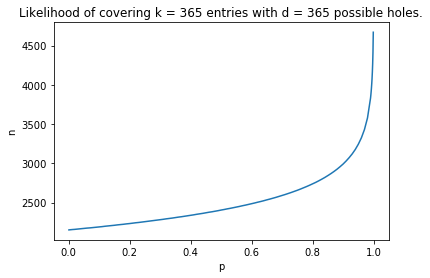

In [8]:
plt.plot(ps, ns)
plt.title("Likelihood of covering k = {0} entries with d = {1} possible holes.".format(k, d))
plt.xlabel('p')
plt.ylabel('n')
plt.show()

These results are pretty counterintuitive, but they just go to show how intuition and probability scenarios tend to clash. It may be interesting to see how *n* responds to variations in *d* and *k*.

### Disclaimer
There may be a mistake in the math or in the implementation of the numerical solver. For smaller values of p and n especially (p < 0.01), the solver fails to converge to significantly smaller than p. (The results of the solver may simply imply that the sharp uptick in probability occurs right at n = 2150, but this claim is dubious without further explanation.) We unfortunately cannot track the value in which the probability stops being negligible (say p > 0.0001) or the function's initial behavior through the method implemented above.

\- DK